In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Cloning into 'ds-assets'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 256 (delta 20), reused 29 (delta 10), pack-reused 216
Receiving objects: 100% (256/256), 43.34 MiB | 6.37 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Updating files: 100% (85/85), done.


# Uncertainty

Uncertainty is omnipresent in machine learning and in data science in general simply because we try to infer properties of a population at large from a small sample of that population.

Consider the Wisconsin breast cancer data set with a few hundred observations.  It represents a tiny fraction of the overall human adult, female population and yet we use this data set to infer the characteristics of cancerous cells and use our machine learning models to predict whether or not a yet undiagnosed cell of an individual not in the training data is cancerous.  Given that the training data represents a tiny sample of the population at large there is some uncertainty connected with any prediction made based on that data.  That is why we predicate any performance claims with a confidence interval acknowledging that there is some uncertainty.

## One Source of Uncertainty

One way to look at the Wisconsin breast cancer data set is as a **sample** of the population at large.  If some other state would conduct a similar study they might create another sample with slightly different characteristics.

Let's study the effect of taking a sample from a domain. We use our iris data set to do this.

## Sampling the Iris Dataset

In [2]:
import pandas as pd
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(4,3)})
from matplotlib.pyplot import show
from statistics import mean
from numpy import percentile

We only use two dimensions of the dataset so that we can easily visualize things.

In [3]:
df = pd.read_csv(home+"iris.csv")[['Petal.Length', 'Petal.Width','Species']]
df.head()

,Petal.Length,Petal.Width,Species
0,1.4,0.2,setosa
1,1.4,0.2,setosa
2,1.3,0.2,setosa
3,1.5,0.2,setosa
4,1.4,0.2,setosa


**Assumption**: Assume that our iris data set is the collection of **all** iris flowers in the world.  Essentially, **this data set is the domain of all iris flowers**.

<Axes: xlabel='Petal.Width', ylabel='Petal.Length'>

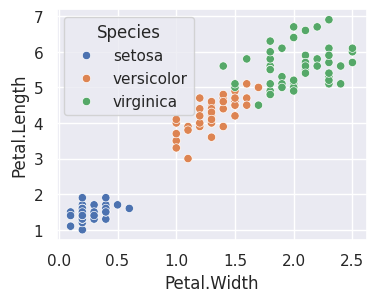

In [4]:
sns.scatterplot(df, x='Petal.Width', y='Petal.Length', hue='Species')

Now assume that we cannot look at all the flowers in our iris domain at the same time.  We can only look at 30 flowers at the same time.  That is, in order to study the flowers we have to **sample** our domain.

In [5]:
sample_size=30

Assume we have 3 different scientist wanting to study the flowers each drawing their own sample in order to do so.

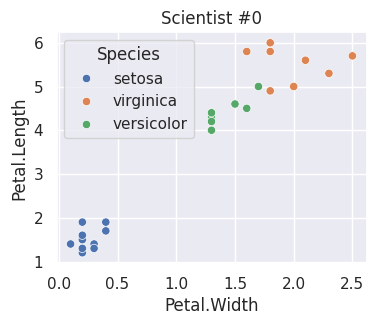

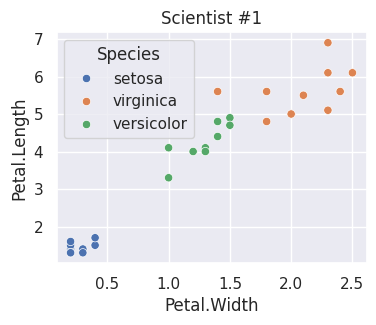

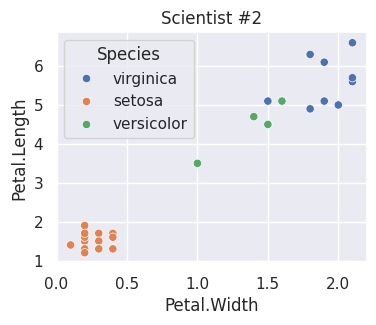

In [6]:
n_scientists=3
samples = []

for i in range(n_scientists):
  samples.append(df.sample(sample_size, axis=0, random_state=i+2))
  sns.scatterplot(samples[i], x='Petal.Width', y='Petal.Length', hue='Species').set_title("Scientist #{}".format(i))
  show()

**Observation**: Notice that due to the random nature of sampling **each scientist has a slightly different view of the iris flower domain**.  The view of the last scientist is particularly worrisome since here the versicolor cluster is practically non-existant.




# Estimating Population Properties

Let's make this observation a bit more concrete.  Let's assume that our scientists are interested in studying the average petal length of  the iris flower.  Given the difference in samples we find that each scientist will have a slightly different outcome,

In [7]:
samples[0]['Petal.Length'].mean() # scientist id: 0

3.3433333333333333

In [8]:
samples[1]['Petal.Length'].mean() # scientist id: 1

3.769999999999999

In [9]:
samples[2]['Petal.Length'].mean() # scientist id: 2

3.2266666666666657

**Observation**: We can directly observe the uncertainty sampling injects into this study.  Each one of the scientists obtains a slightly different result.

However, if we have enough trials (studies) and we average the results of these studies we can retrieve a pretty accurate estimate of the actual average of the petal lengths of the original population!

In [10]:
n_trials = 20
sum_avg = 0

for i in range(n_trials):
  avg = df.sample(sample_size, axis=0, random_state=i+2)['Petal.Length'].mean()
  print("trial #{}: {:.2f}".format(i,avg))
  sum_avg += avg

print("estimated average: {:.2f}".format(sum_avg/n_trials))
print("actual average: {:.2f}".format(df['Petal.Length'].mean()))

trial #0: 3.34
trial #1: 3.77
trial #2: 3.23
trial #3: 4.03
trial #4: 3.88
trial #5: 4.09
trial #6: 3.81
trial #7: 3.37
trial #8: 3.67
trial #9: 3.80
trial #10: 3.59
trial #11: 4.01
trial #12: 3.22
trial #13: 3.89
trial #14: 3.71
trial #15: 4.06
trial #16: 3.60
trial #17: 3.66
trial #18: 3.94
trial #19: 3.53
estimated average: 3.71
actual average: 3.76


That's pretty close...

In [11]:
print("Our estimate is {:.2f}% accurate".format((1-(3.76-3.71)/3.76)*100))

Our estimate is 98.67% accurate


This means we can use repeated samples/trials to estimate population properties.

# The Bootstrap

Here is the problem, is most cases creating these sample/trials is very expensive.  Consider our Wisconsin breast cancer dataset.  In order to construct another dataset like this one would have to recruit hundreds of patients and perform hundreds of biopsies. The cost of doing that just once is prohibitive, let alone repeating it multiple times in order to construct enough trials to be able to estimate population properties.

This is where the **bootstrap** comes in. In the 1990's statistician discovered that a single sample already contains substantial information about the population and that this information can be extracted from the sample by **resampling the sample**.  This is called the bootstrap. Reference: Tibshirani, R. J., & Efron, B. (1993). An introduction to the bootstrap. Monographs on statistics and applied probability, 57(1).

**Observation**: This implies that we can use a single sample to estimate population properties by simply resampling the sample.  The result of this bootstrap procedure is an estimate of the population property together with a probability bound not unlike the confidence interval we used up to this point.

## The Bootstrap Procedure

The bootstrap can be used to estimate any population statistic together with a probability bound based on a single sample using the following steps:

1. Resample our sample as many times as computationally possible (and you have patience for).  The new samples have to have the same size as the original sample, that means, we have to **sample with replacement** in order to get varying samples. We will construct 200 boostrap samples because that number will give us an easy way to compute the 95% bounds.

1. For each sample compute the statistic in question.  

1. Sort the samples according to the value of the statistic in question.

1. Average the values of the sample statistics in order to estimate the population statistic.

1. Extract the bound values from the sorted sample list.



# Bootstrapping the Iris Dataset

Let's try this with our iris dataset.  Let's assume that it is extraordinarily expensive to create a sample of iris flowers...trips to tropical countries, excursions into the jungle, etc.  Therefore we can only afford a single sample:

In [12]:
our_sample = df.sample(sample_size, axis=0, random_state=1)

We are still interested in the average petal length, so what does our sample say?

In [13]:
our_sample['Petal.Length'].mean()

3.55

We know that this a little low compared to the actual population average of 3.76 we computed above and we are not surprised that it doesn't match given the uncertainty of creating samples.

Let's apply the bootstrap procedure to our sample.

In [14]:
n_bootsamples = 200 # this value let's us easily compute the 95% bounds
sample_stats = []

for i in range(n_bootsamples):
  # resample our sample
  bootsample = our_sample.sample(n=our_sample.shape[0],
                                 replace=True,
                                 axis=0,
                                 random_state=i)
  # compute statistic in question
  sample_stats.append(bootsample['Petal.Length'].mean())

# sort the bootstrap samples according to the statistic
sample_stats.sort()

# compute the estimated value of our population statistic
avg = mean(sample_stats)

# estimate the 95% probability bounds
lb = percentile(sample_stats, 2.5)
ub = percentile(sample_stats, 97.5)

print("The population petal length average is {:.2f} with "\
      "the 95% probability bound ({:.2f},{:.2f}).".format(avg,lb,ub))

The population petal length average is 3.54 with the 95% probability bound (2.84,4.16).


The result of the bootstrap tells us that the estimated average petal length of the overall population is 3.54 but the probability bounds tell us that it could be as low as 2.84 and as high as 4.18.

**Observation**: The probability bounds cover the actual population average petal length of 3.76!

Why does this work?  One way to view this is that resampling the sample with replacement exposes different aspects of the underlying domain and with this we are able to compute probability bounds on the desired statistic.

# The Bootstrap and ML

Given that bootstrap samples expose different aspects of the underlying domain we can use this to compute the **expected performance of machine learning algorithms together with a probability bound**.

Let's continue our iris example.  Let's say we want to compute a classification model based on neural networks.  We will continue to use our sample from above to do this work.

In [15]:
our_sample.head()

,Petal.Length,Petal.Width,Species
14,1.2,0.2,setosa
98,3.0,1.1,versicolor
75,4.4,1.4,versicolor
16,1.3,0.4,setosa
131,6.4,2.0,virginica


First we build our rule-of-thumb ANN and capture the uncertainty of building the network on our sample by computing the confidence interval.

In [16]:
from sklearn.neural_network import MLPClassifier
from confint import classification_confint
from sklearn.metrics import accuracy_score

# get data
X  = our_sample.drop(columns=['Species'])
y = our_sample['Species']

# neural network
nnodes = 2*len(list(X.columns))
print("We are using {} nodes".format(nnodes))

# buils model object
model = MLPClassifier(hidden_layer_sizes=(nnodes,),
                      activation='tanh',
                      max_iter=10000,
                      random_state=1)

# train the model
model.fit(X, y) # ANN wants a series as the target

# compute the accuracy of our classifier
predict_y = model.predict(X)
acc = accuracy_score(y, predict_y)
observations = X.shape[0]
lb,ub = classification_confint(acc,observations)

# print accuracy
print("Accuracy with confidence interval: {:3.2f} ({:3.2f}, {:3.2f})"
      .format(acc, lb, ub))

We are using 4 nodes
Accuracy with confidence interval: 0.97 (0.90, 1.00)


Now, let's capture the uncertainty of using our sample by bootstrapping our sample.

In [17]:
n_bootsamples = 200 # this value let's us easily compute the 95% bounds
sample_stats = []

for i in range(n_bootsamples):
  # resample our sample
  bootsample = our_sample.sample(n=our_sample.shape[0],
                                 replace=True,
                                 axis=0,
                                 random_state=i)
  # compute statistic in question
  model = MLPClassifier(hidden_layer_sizes=(nnodes,),
                      activation='tanh',
                      max_iter=10000,
                      random_state=i)
  X = bootsample.drop(columns=['Species'])
  y = bootsample['Species']
  model.fit(X,y)
  predict_y = model.predict(X)
  acc = accuracy_score(y, predict_y)
  sample_stats.append(acc)

# sort the bootstrap samples according to the statistic
sample_stats.sort()

# compute the estimated value of our population statistic
avg = mean(sample_stats)

# estimate the 95% probability bounds
lb = percentile(sample_stats, 2.5)
ub = percentile(sample_stats, 97.5)

print("The accuracy is {:.2f} with a "\
      "95% probability bound ({:.2f},{:.2f}).".format(avg,lb,ub))

The accuracy is 0.97 with a 95% probability bound (0.80,1.00).


**Observation**: Our bootstrapped accuracy and the accuracy of our rule-of-thumb network built on our sample coincide.  In terms of bounds, the bootstrapped confidence bound is a little bit more conservative than the confidence interval we computed above.

# The DS Bootstrap Function

We have embedded all the above computations of the bootstrap into a bootstrap function.

In [18]:
from bootstrap import bootstrap

In [19]:
help(bootstrap)

Help on function bootstrap in module bootstrap:

bootstrap(model, X, y, random_state=None)
    Compute a bootstrapped model score together with its 95% probability 
    bound. If the model object is a classification model then model accuracy 
    is computed and if the model object is a regression model then the R^2 
    score is computed.
    
    Parameters
        model - either a classification or regression model
        X - sklearn style feature matrix
        y - sklearn style target vector
        random_state - controls the sampling of the bootstrap samples, 
                       pass an int for reproducible output across multiple 
                       function calls.
    
    Returns
        (score, lower bound, upper bound)



Let's redo our neural network example with this procedure.

In [20]:
model = MLPClassifier(hidden_layer_sizes=(nnodes,),
                      activation='tanh',
                      max_iter=10000)
X = our_sample.drop(columns=['Species'])
y = our_sample['Species']

score,lb,ub = bootstrap(model,X,y)

print("The accuracy is {:.2f} with a "\
      "95% probability bound ({:.2f},{:.2f}).".format(score,lb,ub))

The accuracy is 0.98 with a 95% probability bound (0.83,1.00).
